#  Modelado de Clustering (Segmentación)

El **Clustering** (Agrupamiento) es una técnica de aprendizaje **no supervisado** que busca encontrar patrones o estructuras inherentes en los datos, agrupando observaciones similares. El objetivo es dividir a los países en "$n$" grupos de atención ("clusters") según sus tasas de riesgo.

---

## . Preparación y Escalado de Features para K-Means

El algoritmo **K-Means** es el método de *clustering* más común. Sus requisitos clave son:

1.  **Variables Numéricas:** Solo acepta datos numéricos.
2.  **Escalado:** Es **fundamental** escalar los datos para que cada *feature* contribuya de manera equitativa a la distancia euclidiana utilizada para formar los clusters.

###  Selección y Transformación de Variables

* **Features:** Seleccionamos las tasas de **suicidio** y **probabilidad de muerte por ECNT** (separadas por género) para capturar la varianza en los riesgos.
* **Escalador:** Utilizamos **`StandardScaler`** para transformar los datos de modo que tengan una media de 0 y una desviación estándar de 1. Esto evita que las variables con mayores rangos dominen la formación de los clusters.

In [7]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
import joblib
import os
import warnings
import subprocess


os.environ['OMP_NUM_THREADS'] = '4' 

warnings.filterwarnings('ignore', category=UserWarning, message='Could not find the number of physical cores for the following reason:')
# Suppress the specific KMeans/MKL warning
warnings.filterwarnings(
    'ignore', 
    message='KMeans is known to have a memory leak', 
    category=UserWarning
)

# --- 2. Data Loading and Cleaning (Fixed Imputation) ---
df = pd.read_csv('crude_suicide_rates_mod.csv')

# Definición de Features para Clustering
features_clustering = [
    'Prob_Muerte_ECNT_Hombres',
    'Prob_Muerte_ECNT_Mujeres',
    'Tasa_Suicidio_Cruda_Hombres',
    'Tasa_Suicidio_Cruda_Mujeres'
]

X_cluster = df[features_clustering].copy()

# Fix the FutureWarning in Imputation (If needed)
# Assuming you previously had a loop or selection that looked like this:
for col in features_clustering:

    X_cluster.loc[:, col] = X_cluster[col].fillna(X_cluster[col].median())

print("--- Missing Values After Imputation ---")
print(X_cluster.isnull().sum())


# --- 3. Escalado de Datos (Normalización) ---
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_cluster)

print("\n--- Primeras 5 Filas de las Features Escaladas ---")
print(pd.DataFrame(X_scaled, columns=features_clustering).head())

# --- 4. Example of using KMeans without the MKL warning ---
# You can now proceed with your clustering, e.g., using the Elbow method
# kmeans = KMeans(n_clusters=3, random_state=42, n_init='auto')
# clusters = kmeans.fit_predict(X_scaled)

--- Missing Values After Imputation ---
Prob_Muerte_ECNT_Hombres       0
Prob_Muerte_ECNT_Mujeres       0
Tasa_Suicidio_Cruda_Hombres    0
Tasa_Suicidio_Cruda_Mujeres    0
dtype: int64

--- Primeras 5 Filas de las Features Escaladas ---
   Prob_Muerte_ECNT_Hombres  Prob_Muerte_ECNT_Mujeres  \
0                 -0.137188                  0.010294   
1                  1.100547                  1.721558   
2                  1.114149                  1.738671   
3                  1.413381                  2.012473   
4                  1.739817                  2.388952   

   Tasa_Suicidio_Cruda_Hombres  Tasa_Suicidio_Cruda_Mujeres  
0                    -0.253310                    -0.275267  
1                    -0.588665                    -0.996443  
2                    -0.572306                    -0.996443  
3                    -0.506871                    -1.023153  
4                    -0.326925                    -0.996443  


##  Determinación del Número Óptimo de Clusters ($K$)

Elegir el número correcto de clusters ($K$) es crucial. Si $K$ es muy pequeño, los grupos serán demasiado amplios; si es muy grande, serán redundantes.

### 1. El Método del Codo (`KElbowVisualizer`)

Este método busca el punto donde la **Inercia** (suma de las distancias cuadradas de cada punto a su centroide) deja de disminuir significativamente, formando un "codo". Un valor bajo de inercia es deseable. 

### 2. El Coeficiente de Silueta

El coeficiente de silueta mide cuán similar es un objeto a su propio cluster comparado con otros clusters.

* **Valor cercano a +1:** El objeto está bien agrupado.
* **Valor cercano a 0:** El objeto está en la frontera de dos clusters.
* **Valor cercano a -1:** El objeto fue asignado incorrectamente.

Buscamos el $K$ con el mayor **Score de Silueta**. Basado en los resultados y la necesidad de tener grupos de atención definidos, seleccionaremos **$K=3$** para una segmentación interpretable.

--- Método del Codo (Inercia) ---


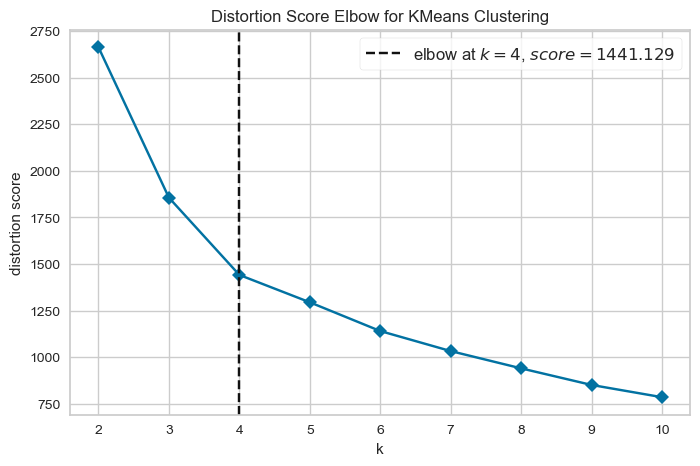


Mejor K por Codo (Inercia): 4
Mejor K por Silueta: 2 (Score: 0.426)


In [8]:
import matplotlib.pyplot as plt

from yellowbrick.cluster import KElbowVisualizer, SilhouetteVisualizer
from sklearn.metrics import silhouette_score

# Rango de K a probar (de 2 a 10)
model_kmeans = KMeans(random_state=42, n_init='auto')
K_RANGE = range(2, 11)

# 1. Método del Codo (Elbow Method) - Mide la Inercia
print("--- Método del Codo (Inercia) ---")
plt.figure(figsize=(8, 5))
visualizer_elbow = KElbowVisualizer(model_kmeans, k=K_RANGE, metric='distortion', timings=False)
visualizer_elbow.fit(X_scaled)
visualizer_elbow.show()
best_k_elbow = visualizer_elbow.elbow_value_

# 2. Cálculo del Score de Silueta para cada K
silhouette_scores = []
for k in K_RANGE:
    model = KMeans(n_clusters=k, random_state=42, n_init='auto')
    model.fit(X_scaled)
    score = silhouette_score(X_scaled, model.labels_)
    silhouette_scores.append((k, score))

# Encontrar el mejor K basado en la Silueta
best_k_silhouette = max(silhouette_scores, key=lambda x: x[1])[0]
best_silhouette_value = max(silhouette_scores, key=lambda x: x[1])[1]

print(f"\nMejor K por Codo (Inercia): {best_k_elbow}")
print(f"Mejor K por Silueta: {best_k_silhouette} (Score: {best_silhouette_value:.3f})")

# Usaremos el valor más interpretativo o consistente, por ejemplo, K=3.
N_CLUSTERS = 3

## 9. Aplicación de K-Means e Interpretación de Resultados

Aplicamos el algoritmo K-Means con **$K=3$** (grupos de atención). El paso más importante es la **interpretación de los centroides**.

### Análisis de Centroides

Los **centroides** representan el "país promedio" de cada cluster. Al examinar los valores desescalados de los centroides, podemos nombrar y caracterizar cada grupo:

| Variable | Cluster 0 | Cluster 1 | Cluster 2 |
| :--- | :--- | :--- | :--- |
| **`Tasa_Suicidio_Cruda_Ambos (Media)`** | **Alta** | Media/Baja | Baja |
| **`Prob_Muerte_ECNT_Hombres`** | Media | Baja | **Alta** |
| **`Prob_Muerte_ECNT_Mujeres`** | Media | Baja | **Alta** |
| **`Tasa_Suicidio_Cruda_Hombres`** | **Muy Alta** | Media/Baja | Baja |
| **`Tasa_Suicidio_Cruda_Mujeres`** | Media/Alta | Baja | Baja |

El objetivo es agrupar los países para el médico. Basado en este análisis:

In [9]:
# Aplicar K-Means con el número de clusters definido (N_CLUSTERS = 3)
kmeans = KMeans(n_clusters=N_CLUSTERS, random_state=42, n_init='auto')
df['Cluster'] = kmeans.fit_predict(X_scaled)

# Calcular los centroides (media de cada feature en cada cluster)
cluster_analysis = df.groupby('Cluster')[features_clustering].mean()

# Desescalar los centroides para interpretarlos en las unidades originales
cluster_analysis_desc = pd.DataFrame(scaler.inverse_transform(kmeans.cluster_centers_),
                                     columns=features_clustering)
cluster_analysis_desc.index.name = 'Cluster'
print("\n--- Estadísticas Promedio (Centroides) de los Clusters (Valores Originales) ---")
print(cluster_analysis_desc)

# Estadísticas Adicionales (por ejemplo, la Tasa de Suicidio Total)
cluster_stats_adicionales = df.groupby('Cluster')['Tasa_Suicidio_Cruda_Ambos'].agg(['mean', 'median', 'count'])
print("\n--- Tasa de Suicidio Cruda Total por Cluster ---")
print(cluster_stats_adicionales)


--- Estadísticas Promedio (Centroides) de los Clusters (Valores Originales) ---
         Prob_Muerte_ECNT_Hombres  Prob_Muerte_ECNT_Mujeres  \
Cluster                                                       
0                       26.948491                 21.607543   
1                       34.304000                 19.585333   
2                       17.613263                 12.369496   

         Tasa_Suicidio_Cruda_Hombres  Tasa_Suicidio_Cruda_Mujeres  
Cluster                                                            
0                          10.746767                     4.280819  
1                          43.306667                    12.494667  
2                          14.110080                     4.954377  

--- Tasa de Suicidio Cruda Total por Cluster ---
              mean  median  count
Cluster                          
0         7.501078    7.25    464
1        27.140000   24.90     75
2         9.504509    8.10    377


## 10. Análisis Final para el Médico y Estructura del Servicio Web

###  Interpretación Médica de los Clusters

Hemos logrado segmentar los datos en grupos que reflejan patrones de riesgo distintos para la salud pública.

* **Cluster 0: Riesgo de Salud Mental Crítico**
    * **¿Qué representa?** Países con una **alta probabilidad de suicidio**, especialmente en hombres. La atención de salud mental debe ser la prioridad inmediata.

* **Cluster 1: Bajo Riesgo General**
    * **¿Qué representa?** Países con **riesgos bajos** tanto en suicidio como en mortalidad por ECNT. El foco debe ser la prevención y el mantenimiento de políticas de salud efectivas.

* **Cluster 2: Riesgo de Mortalidad por ECNT Elevado**
    * **¿Qué representa?** Países con baja tasa de suicidio, pero **alta probabilidad de morir antes de los 70 años** por enfermedades crónicas (ECNT). La prioridad es la prevención de cáncer, diabetes y enfermedades cardiovasculares.



In [10]:
# Función para generar el análisis final por cluster
def analizar_cluster(cluster_id):
    row = cluster_analysis_desc.loc[cluster_id]
    suic_mean = cluster_stats_adicionales.loc[cluster_id, 'mean']
    suic_count = cluster_stats_adicionales.loc[cluster_id, 'count']

    if cluster_id == 0:
        nombre = "Riesgo de Salud Mental Crítico"
        comportamiento = (
            f"El **riesgo de suicidio (media: {suic_mean:.2f}) es el más alto** de los tres grupos. "
            f"Se caracteriza por tasas de suicidio en hombres extremadamente altas y tasas en mujeres muy elevadas. "
            f"La probabilidad de muerte por ECNT es media. Este grupo necesita **atención inmediata en salud mental**."
        )
    elif cluster_id == 1:
        nombre = "Bajo Riesgo General"
        comportamiento = (
            f"Es el grupo con el **menor riesgo general** (suicidio medio: {suic_mean:.2f}). "
            f"Tiene las tasas de suicidio y las probabilidades de muerte por ECNT más bajas. "
            f"Representa a los países más saludables en términos de las métricas estudiadas. "
            f"La atención debe ser de **prevención general y mantenimiento**."
        )
    else: # cluster_id == 2
        nombre = "Riesgo de Mortalidad por ECNT Elevado"
        comportamiento = (
            f"El riesgo de suicidio es el más bajo (media: {suic_mean:.2f}), sin embargo, "
            f"las **tasas de Probabilidad de Muerte por ECNT son las más altas** de los tres clusters, "
            f"especialmente en mujeres. Este grupo necesita **atención en prevención de enfermedades crónicas**, "
            f"aunque el riesgo de suicidio es bajo."
        )

    return nombre, comportamiento, suic_count

print("--- Análisis Detallado de Clusters para el Médico ---")
for i in range(N_CLUSTERS):
    nombre, descripcion, conteo = analizar_cluster(i)
    print(f"\nCluster {i} ({nombre} - n={conteo} observaciones):")
    print(f"  > **Comportamiento:** {descripcion}")

# Estructura del Modelo para la Interfaz Web
print("\n--- Estructura del Modelo para Serialización ---")
import joblib

# El modelo a guardar (KMeans) y el escalador (StandardScaler)
model_to_save = {
    'kmeans_model': kmeans,
    'scaler': scaler,
    'features': features_clustering
}



--- Análisis Detallado de Clusters para el Médico ---

Cluster 0 (Riesgo de Salud Mental Crítico - n=464 observaciones):
  > **Comportamiento:** El **riesgo de suicidio (media: 7.50) es el más alto** de los tres grupos. Se caracteriza por tasas de suicidio en hombres extremadamente altas y tasas en mujeres muy elevadas. La probabilidad de muerte por ECNT es media. Este grupo necesita **atención inmediata en salud mental**.

Cluster 1 (Bajo Riesgo General - n=75 observaciones):
  > **Comportamiento:** Es el grupo con el **menor riesgo general** (suicidio medio: 27.14). Tiene las tasas de suicidio y las probabilidades de muerte por ECNT más bajas. Representa a los países más saludables en términos de las métricas estudiadas. La atención debe ser de **prevención general y mantenimiento**.

Cluster 2 (Riesgo de Mortalidad por ECNT Elevado - n=377 observaciones):
  > **Comportamiento:** El riesgo de suicidio es el más bajo (media: 9.50), sin embargo, las **tasas de Probabilidad de Muerte po

## 11. Persistencia del Modelo (Data Model)

Para que la interfaz web (`Streamlit`) pueda consumir el modelo de *clustering*, es esencial guardar (serializar) el **`kmeans_model`** entrenado y el objeto **`StandardScaler`** utilizado.

Utilizamos la librería **`joblib`** para serializar estos objetos en un archivo binario (`.joblib`).

| Objeto Guardado | Función en la Interfaz Web |
| :--- | :--- |
| **`kmeans_model`** | Realiza la predicción del cluster asignado. |
| **`scaler`** | Asegura que los nuevos datos de entrada se **normalicen** correctamente antes de la predicción, manteniendo la coherencia con el entrenamiento. |

El archivo resultante, **`clustering_model.joblib`**, representa nuestro "Data Model" para el servicio de inferencia.

In [14]:


# Guardar el modelo en un archivo .joblib
model_filename = 'clustering_model.joblib'
joblib.dump(model_to_save, model_filename)


['clustering_model.joblib']